In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import datetime
import json
import re

import scipy.stats as S
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, StratifiedKFold, GroupKFold
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, average_precision_score, matthews_corrcoef
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

from collections import Counter
from tqdm.notebook import tqdm

from roc_comparison.compare_auc_delong_xu import delong_roc_test

# Setup

In [2]:
# from numpy.random import MT19937
# from numpy.random import RandomState, SeedSequence
RANDOM_STATE = 22

In [3]:
sns.set_context("notebook")
sns.set_style("darkgrid")

In [4]:
def cols(df, startswith):
    return df.columns[df.columns.map(lambda x: x.startswith(startswith))]

def ncols(df, startswith):
    return df.columns[df.columns.map(lambda x: not x.startswith(startswith))]

In [5]:
def deep_map(d, mapfunc):
    results = {}
    for key, value in d.items():
        if isinstance(d[key], dict):
            results[key] = deep_map(d[key], mapfunc)
        else:
            results[key] = mapfunc(value)
    return results

In [6]:
def index_lv2(df, value):
    return df.iloc[df.index.get_locs([slice(None), value])]

In [7]:
def permtest(true, pred, statistic, n_resamples=1000, random_state=None):
    if random_state is not None:
        rng = np.random.default_rng(random_state)
    else:
        rng = np.random
    sfl = true.copy()
    metric = statistic(true, pred)
    n_greater = 0
    for _ in range(n_resamples):
        rng.shuffle(sfl)
        if statistic(sfl, pred) > metric:
            n_greater += 1
    return n_greater / n_resamples

In [8]:
PHASE_NAME = {
    "c": "non-contrast",
    "a": "arterial",
    "v": "venous",
    "d": "delayed"
}

# Read Data

In [9]:
data = pd.read_csv("./results-ct4phase-data.csv")[["custom_studyId", "custom_age", "custom_gender", "custom_ki67-value"]]
df = pd.read_csv("./results-ct4phase-3d.csv")

data2 = pd.read_csv("./results-ct4phase-comp-data.csv")[["custom_studyId", "custom_age", "custom_gender", "custom_ki67-value"]]
df2 = pd.read_csv("./results-ct4phase-comp-3d.csv")

data = pd.concat([data, data2], axis=0, ignore_index=True)
df = pd.concat([df, df2], axis=0, ignore_index=True)

In [10]:
df.set_index(["custom_studyId", "custom_phase"], inplace=True)
data.set_index("custom_studyId", inplace=True)

In [11]:
# Add Vendor data
VENDOR_SEARCH_OUTPUT_DIR = "tmp_vendors_search"
if not os.path.exists(VENDOR_SEARCH_OUTPUT_DIR):
    raise FileNotFoundError(f"Vendor data not found in {VENDOR_SEARCH_OUTPUT_DIR}")

for f in os.listdir(VENDOR_SEARCH_OUTPUT_DIR):
    vendor = os.path.splitext(f)[0].upper()
    vendor_file = os.path.join(VENDOR_SEARCH_OUTPUT_DIR, f)
    with open(vendor_file, 'r') as f:
        for studyId in f.readlines():
            studyId = studyId.strip()
            if studyId in data.index.values:
                data.loc[studyId, "custom_vendor"] = vendor

# Assert all data has vendor set
assert(data[data["custom_vendor"].isnull()].shape[0] == 0)

In [13]:
# Ensure all studies have 4 phases, and all phases have their radiomics features extracted
_a = df.index.get_level_values(0).nunique()
_b = data.index.nunique()
assert(_a == _b)
assert(_a * 4 == len(df.index))
_a

383

In [14]:
Counter(df.columns.map(lambda x: x.split('_', 1)[0]))

Counter({'original': 107, 'diagnostics': 22})

In [15]:
Counter(cols(df, "original").map(lambda x: x.split('_', 3)[1])), len(cols(df, "original"))

(Counter({'glcm': 24,
          'firstorder': 18,
          'glrlm': 16,
          'glszm': 16,
          'shape': 14,
          'gldm': 14,
          'ngtdm': 5}),
 107)

In [16]:
data["custom_ki67-gt-10"] = data["custom_ki67-value"].map(lambda x: x > 10)

# Data distribution

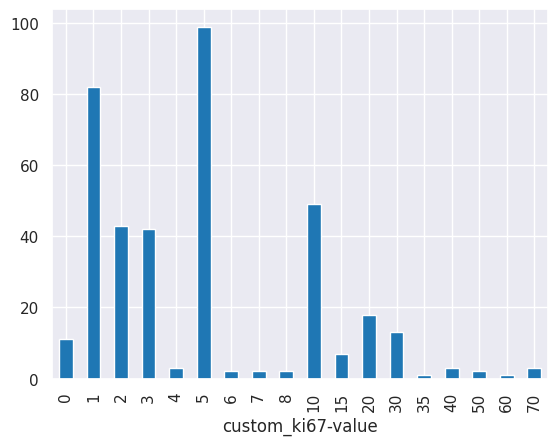

In [17]:
ax = data.groupby("custom_ki67-value").size().plot(kind='bar')
ax.plot([0, 0], [1, 1], label="a")

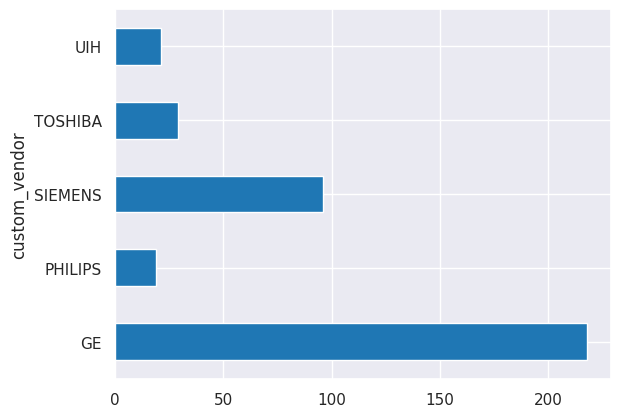

In [18]:
ax = data.groupby("custom_vendor").size().plot(kind='barh')

In [19]:
data.groupby("custom_ki67-gt-10").size()

custom_ki67-gt-10
False    335
True      48
dtype: int64

Join tables

In [20]:
df = df.reset_index(level=1).join(data, how="left").set_index("custom_phase", append=True)

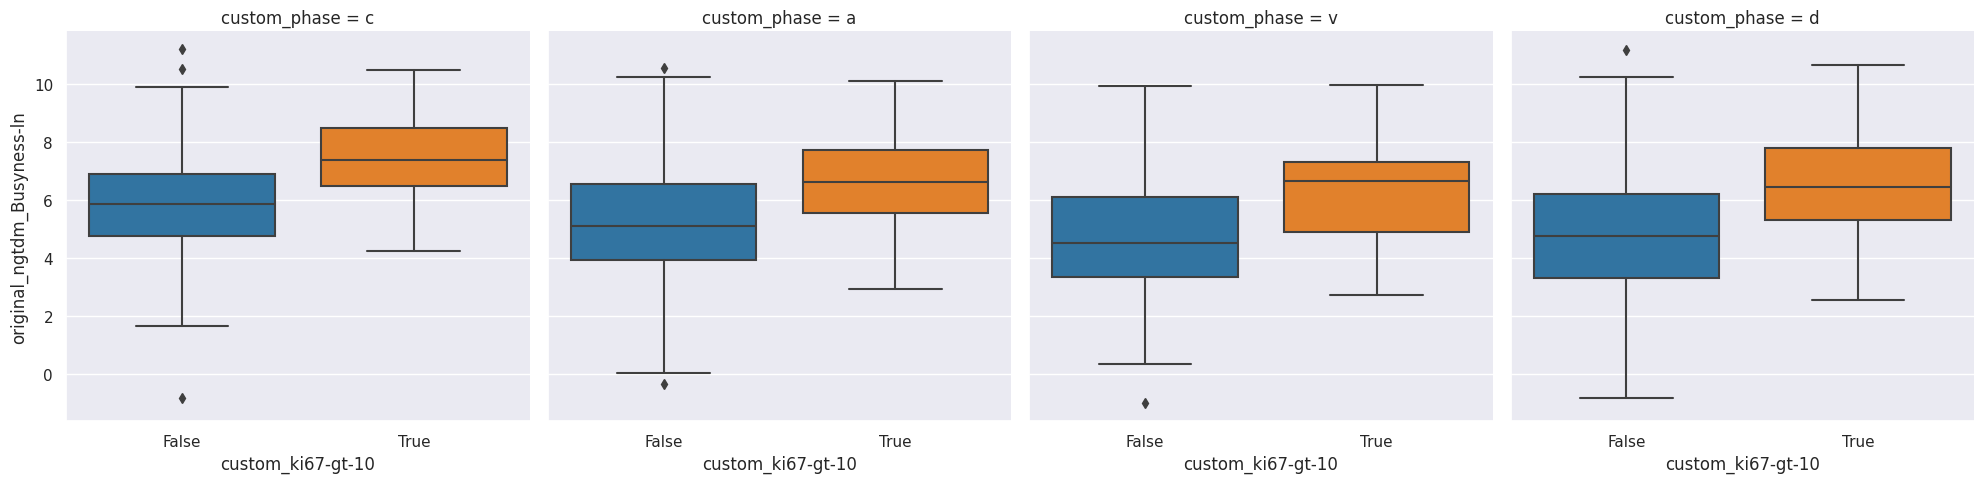

In [21]:
# NGTDM Busyness by phase
_data = df.reset_index(1).copy()
_data["original_ngtdm_Busyness-ln"] = np.log(_data["original_ngtdm_Busyness"].values)
sns.catplot(x="custom_ki67-gt-10", y="original_ngtdm_Busyness-ln", col="custom_phase", data=_data, kind="box")

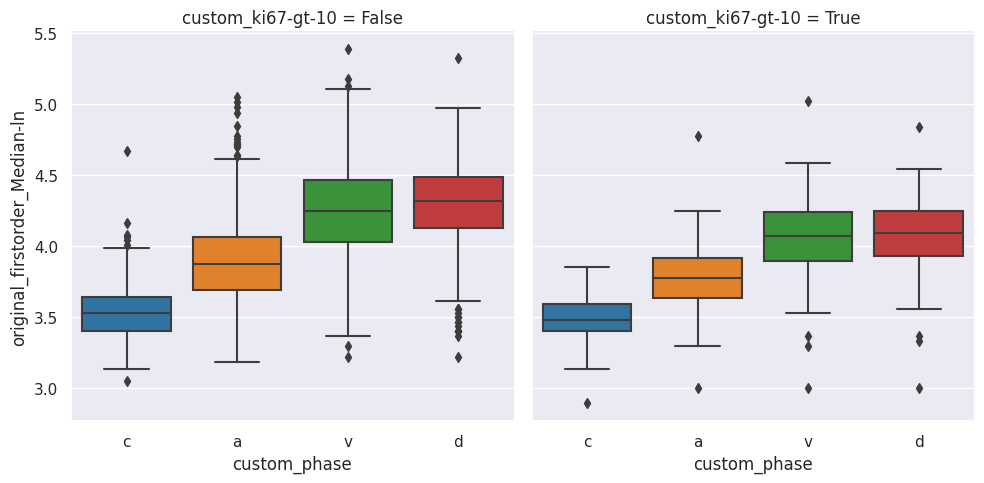

In [22]:
# Median
_data = df.reset_index(1).copy()
_data["original_firstorder_Median-ln"] = np.log(_data["original_firstorder_Median"])
_dmask = _data["original_firstorder_Median"] < 500
sns.catplot(x="custom_phase", y="original_firstorder_Median-ln", col="custom_ki67-gt-10", data=_data[_dmask], kind="box")

# Intra- and Inter-observer validation

In [23]:
intra = pd.read_csv("./results-ct4phase-intraobserver.csv")
inter = pd.read_csv("./results-ct4phase-interobserver.csv")

intra.shape, inter.shape

((80, 131), (80, 131))

In [24]:
intra.set_index(["custom_studyId", "custom_phase"], inplace=True)
inter.set_index(["custom_studyId", "custom_phase"], inplace=True)

In [25]:
ac = cols(intra, "original")
inter_all = inter.copy()
inter_all["rater"] = 0
inter_all["target"] = inter_all.reset_index().apply(lambda x: f"{x['custom_studyId']}-{x['custom_phase']}", axis=1).values
inter1 = df.loc[inter.index, ac]
inter1["rater"] = 1
inter1["target"] = inter1.reset_index().apply(lambda x: f"{x['custom_studyId']}-{x['custom_phase']}", axis=1).values
inter_all = pd.concat([inter_all, inter1], ignore_index=True, axis=0)
inter_all = inter_all[inter_all["target"].map(lambda x: "D5224183" not in x)]

available_inter = []
for c in ac:
    # Two-way random effects, absolute agreement, single rater/measurement
    icc = pg.intraclass_corr(inter_all, targets="target", raters="rater", ratings=c)
    icc = icc.set_index("Type").loc["ICC2", "ICC"]
    if icc > 0.75:
        available_inter.append(c)

len(available_inter)

81

In [26]:
ac = cols(intra, "original")
intra_all = intra.copy()
intra_all["rater"] = 0
intra_all["target"] = intra_all.reset_index().apply(lambda x: f"{x['custom_studyId']}-{x['custom_phase']}", axis=1).values
intra1 = df.loc[intra.index, ac]
intra1["rater"] = 1
intra1["target"] = intra1.reset_index().apply(lambda x: f"{x['custom_studyId']}-{x['custom_phase']}", axis=1).values
intra_all = pd.concat([intra_all, intra1], ignore_index=True, axis=0)

available_intra = []
for c in ac:
    # Two-way random effects, absolute agreement, single rater/measurement
    icc = pg.intraclass_corr(intra_all, targets="target", raters="rater", ratings=c)
    icc = icc.set_index("Type").loc["ICC2", "ICC"]
    if icc > 0.75:
        available_intra.append(c)

len(available_intra)

86

In [27]:
available_columns = [i for i in available_inter if i in available_intra]
len(available_columns)

79

# Train test split

In [28]:
VENDOR_GROUPS = {
    "GE": "Training",
    "SIEMENS": "Validation 1",
    "UIH": "Validation 2",
    "TOSHIBA": "Validation 2",
    "PHILIPS": "Validation 2",
}

df["custom_vendor-group"] = df["custom_vendor"].map(VENDOR_GROUPS)

In [29]:
NUMBER_RE = re.compile(r"[0-9]+")

def _to_val(x):
    m = NUMBER_RE.match(x)
    if m is None:
        return 0
    return int(m[0])

def _diameter_grp(x):
    if x < 50:
        return "$\leq$ 5 cm"
    else:
        return "> 5 cm"

df["custom_age-value"] = df["custom_age"].map(_to_val)
df["custom_gender-value"] = (df["custom_gender"] == "男").map(int)
df["custom_diameter-group"] = df["original_shape_Maximum2DDiameterSlice"].map(_diameter_grp)

In [31]:
_cer_col = "original_firstorder_Median"
_cer = df.reset_index()[["custom_studyId", "custom_vendor-group", "custom_ki67-gt-10", "custom_phase", _cer_col]]
_cer = _cer.pivot_table(values=_cer_col, index=["custom_studyId", "custom_vendor-group", "custom_ki67-gt-10"], columns="custom_phase").reset_index([1, 2])
_cer["CER"] = (_cer[list("cavd")].max(1) / _cer["c"])

df = df.join(_cer["CER"].rename("custom_cer"))

# Cross validation and model tuning

In [32]:
original_cols = available_columns
len(original_cols)

79

In [33]:
df.groupby("custom_vendor-group").size()

custom_vendor-group
Training        872
Validation 1    384
Validation 2    276
dtype: int64

## Generic

In [34]:
def select_features(config, kind="corr"):
    results = {}
    phase = config["phase"]
    df_train = config["data"]["df_train"]
    original_cols = config["original_cols"]
    X = config["data"]["X_train"][original_cols]
    y = config["data"]["y_train"]

#     ee = EllipticEnvelope(random_state=RANDOM_STATE, contamination=0.05)
#     mask = ee.fit_predict(df_train[cols(df_train, "original")]) > 0
#     df_train = df_train.iloc[mask]

    if kind == "corr":
        _t = pd.DataFrame()
        for col in original_cols:
            # Calculate spearman correlation
            corr, p = S.spearmanr(X[col], y)
            _t.loc[col, "coef"] = corr
            _t.loc[col, "p"] = p

        _t.sort_values("coef", key=np.abs, ascending=False, inplace=True)
        # Calculate inter-variable correlation
        cols_to_include = []
        corr = X.corr("spearman").abs()
        for v in _t.index:
            if cols_to_include and corr.loc[cols_to_include, v].values.max() > config["intervariable_corr_thresh"]:
                continue
            cols_to_include.append(v)
            if len(cols_to_include) == config["n_features"]:
                break
        results["cols_to_include"] = np.array(cols_to_include)
    elif kind == "anova":
        results["cols_to_include"] = []
        shape_selector = SelectKBest(k=2)
        shape_selector.fit(X[cols(X, "original_shape")], y)
        results["cols_to_include"].append(shape_selector.get_feature_names_out(cols(X, "original_shape")))

        texture_selector = SelectKBest(k=config["n_features"] - 2)
        texture_selector.fit(X[ncols(X, "original_shape")], y)
        results["cols_to_include"].append(texture_selector.get_feature_names_out(ncols(X, "original_shape")))

        results["shape_selector"] = shape_selector
        results["texture_selector"] = texture_selector
        results["cols_to_include"] = np.concatenate(results["cols_to_include"], axis=0)

    # Plot data distribution
    nr, nc, figsize = config["feature_plot_nr"], config["feature_plot_nc"], config["feature_plot_figsize"]

    fig, ax = plt.subplots(nr, nc, figsize=(nc * figsize, nr * figsize), sharex=True, dpi=config["dpi"])
    for row in range(nr):
        for col in range(nc):
            if col + row * nc >= len(results["cols_to_include"]): continue
            axi = ax[row][col]
            coli = results["cols_to_include"][col + row * nc]
            for p, color in zip("cavd", ["blue", "red", "orange", "green"]):
                sns.regplot(x="custom_ki67-value", y=coli, data=index_lv2(df_train, p), color=color, ax=axi, marker='.', label=f"{PHASE_NAME[p]} phase", truncate=False)
            axi.axvline(9.5, color="black", linestyle='--')
#             axi.set_xscale('log')
            axi.set_xlim((0, 70))
            axi.set_ylabel(coli.split("_", 1)[-1])

    handles, labels = axi.get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.subplots_adjust(wspace=0.4)
    plt.suptitle(f"Distribution of included features ({PHASE_NAME[phase]} phase)")
    plt.savefig(f"{config['path']['output_dir']}/feature_distribution-{phase}.jpg")

    # Plot heatmap
    plt.figure(figsize=(12, 12), dpi=config["dpi"])
    sns.heatmap(df[results["cols_to_include"]].corr("spearman").abs(), cmap="Greys_r")
    plt.title(f"Correlation of included features ({PHASE_NAME[phase]} phase)")
    plt.savefig(f"{config['path']['output_dir']}/feature_correlation-{phase}.jpg")

    return results

def baysian_search(config, cols_to_include):
    from skopt import BayesSearchCV
    from skopt.plots import plot_objective

    phase = config["phase"]
    X = config["data"]["X_train"][cols_to_include]
    y = config["data"]["y_train"]

    opt = BayesSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE, **config["model"]["params"]),
        config["model"]["opt_params"],
        n_iter=config["model"]["opt_iters"],
        scoring=lambda est, x, y: roc_auc_score(y, est.predict_proba(x)[:, 1]),
        cv=config["cv"],
        n_jobs=-1,
        random_state=RANDOM_STATE,
        return_train_score=True,
        verbose=1,
    )

    opt.fit(X, y)

    # Plot
    plt.figure(figsize=(8, 6), dpi=config["dpi"])
    plot_objective(opt.optimizer_results_[0])
    plt.suptitle(f"Partial dependence plot ({PHASE_NAME[phase]} phase)")
    plt.savefig(f"{config['path']['output_dir']}/opt_pdp-{phase}.jpg")
    return {"opt": opt}

def fit_model(config, model_params, cols_to_include):
    X_train = config["data"]["X_train"][cols_to_include]
    y_train = config["data"]["y_train"]
    X_test = config["data"]["X_test"][cols_to_include]
    y_test = config["data"]["y_test"]

    model = RandomForestClassifier(random_state=RANDOM_STATE, **model_params)
    model.fit(X_train, y_train)
    return {"model": model}

def plot_feature_importance(config, model, cols_to_include):
    results = {}
    X_train = config["data"]["X_train"][cols_to_include]
    y_train = config["data"]["y_train"]
    X_test = config["data"]["X_test"][cols_to_include]
    y_test = config["data"]["y_test"]
    phase = config["phase"]

    results_train = permutation_importance(model, X_train, y_train, scoring=lambda est, x, y: roc_auc_score(y, est.predict_proba(x)[:, 1]), random_state=RANDOM_STATE, n_repeats=10, n_jobs=-1)
    results_test = permutation_importance(model, X_test, y_test, scoring=lambda est, x, y: roc_auc_score(y, est.predict_proba(x)[:, 1]), random_state=RANDOM_STATE, n_repeats=10, n_jobs=-1)

    results["feature_importances"] = pd.DataFrame(
        np.array([cols_to_include, model.feature_importances_, results_train["importances_mean"], results_test["importances_mean"]]).T,
        columns=["Column", "Importance", "Permutation Importance (train)", "Permutation Importance (test)"]
    ).sort_values("Permutation Importance (train)", ascending=False).set_index("Column")

    # Plot train
    sorted_importances_idx = results_train.importances_mean.argsort()
    importances_train = pd.DataFrame(
        results_train.importances[sorted_importances_idx].T,
        columns=cols_to_include[sorted_importances_idx],
    )
    ax = importances_train.plot(kind="box", vert=False, whis=10, figsize=(8, 6))
    ax.set_title(f"Permutation Importances ({PHASE_NAME[phase]} phase)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.savefig(f"{config['path']['output_dir']}/permutation_importance_train-{phase}.jpg", dpi=config["dpi"])

    return results

def validation(config, model, cols_to_include):
    results = {}
    X_train = config["data"]["X_train"][cols_to_include]
    y_train = config["data"]["y_train"]
    X_test = config["data"]["X_test"][cols_to_include]
    y_test = config["data"]["y_test"]
    phase = config["phase"]

    # auc values
    results["metrics_train"] = get_metrics(model, X_train, y_train)
    results["metrics_test"] = get_metrics(model, X_test, y_test)
    auc_train, auc_test = results["metrics_train"]["auc"], results["metrics_test"]["auc"]

    # ROC
    plt.figure(figsize=(8, 6), dpi=config["dpi"])
    fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
    plt.plot(fpr, tpr, 'b-', label=f"Train (AUC={'%.2f' % auc_train})")
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, 'r-', label=f"Test (AUC={'%.2f' % auc_test})")

    plt.plot((0, 1), (0, 1), 'k--')
    plt.title(f"ROC for RF model in {PHASE_NAME[phase]} phase")
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig(f"{config['path']['output_dir']}/roc-{phase}.jpg")
    return results

def get_metrics(model, X, y, cutoff = None):
    results = {}
    y_pred = model.predict_proba(X)[:, 1]
    if cutoff:
        results["cutoff"] = cutoff
        y_pred_int = (y_pred >= cutoff).astype(int)
    else:
        y_pred_int = np.round(y_pred).astype(int)
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred_int).ravel()
    results["tn"], results["fp"] = tn, fp
    results["fn"], results["tp"] = fn, tp
    # Other metrics
    results["sensitivity"] = tp / (tp + fn)
    results["specificity"] = tn / (tn + fp)
    results["auc"] = roc_auc_score(y, y_pred)
    results["acc"] = accuracy_score(y, y_pred_int)
    results["pr_auc"] = average_precision_score(y, y_pred)
    results["mcc"] = matthews_corrcoef(y, y_pred_int)
    return results

def plot_roc_vendor(config, model, cols_to_include, key="custom_vendor", fn="vendor"):
    results = {}
    df_train = config["data"]["df_train"]
    df_test = config["data"]["df_test"]
    X_train = config["data"]["X_train"][cols_to_include]
    y_train = config["data"]["y_train"]
    phase = config["phase"]
    train_vendor = df_train[key].iloc[0]

    results[train_vendor] = get_metrics(model, X_train, y_train)

    plt.figure(figsize=(8, 6), dpi=config["dpi"])
    colors = sns.color_palette("hls", len(df_test[key].unique()) + 1)
    fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
    auc = results[train_vendor]["auc"]
    plt.plot(fpr, tpr, color=colors[0], label=f"{train_vendor} (n={y_train.shape[0]}, AUC={'%.2f' % auc})")

    vendors_test = sorted(df_test[key].unique())
    for [vendor, color] in zip(vendors_test, colors[1:]):
        df_vendor = df_test[df_test[key] == vendor]
        X_test = index_lv2(df_vendor, phase)[cols_to_include]
        y_test = index_lv2(df_vendor, phase)[config["target_col"]]
        results[vendor] = get_metrics(model, X_test, y_test)
        auc = results[vendor]["auc"]

        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, color=color, label=f"{vendor} (n={y_test.shape[0]}, AUC={'%.2f' % auc})")

    plt.plot((0, 1), (0, 1), 'k--')
    plt.title(f"ROC of RF model by different vendor in {PHASE_NAME[phase]} phase")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig(f"{config['path']['output_dir']}/roc-{fn}-{phase}.jpg")
    return results

def ensemble(config, models, cols_to_include, key="custom_vendor", fn="vendor", plot_train_valid=True, delong=True, perm=False, ensemble_cols=None):
    results = {}
    df_train = config["data"]["df_train"]
    df_test = config["data"]["df_test"]
    target_col = config["target_col"]
    train_vendor = df_train[key].iloc[0]
    vendors_test = sorted(df_test[key].unique())

    ensemb_train = pd.DataFrame()
    ensemb_test = pd.DataFrame()
    for (phase, model) in models.items():
        X_train = index_lv2(df_train, phase)[cols_to_include[phase]]
        ensemb_train = pd.concat([ensemb_train, pd.Series(model.predict_proba(X_train)[:, 1], name=phase, index=X_train.index.get_level_values(0).drop_duplicates())], axis=1)
        X_test = index_lv2(df_test, phase)[cols_to_include[phase]]
        ensemb_test = pd.concat([ensemb_test, pd.Series(model.predict_proba(X_test)[:, 1], name=phase, index=X_test.index.get_level_values(0).drop_duplicates())], axis=1)

    if ensemble_cols:
        phase = "c"
        scaler = MinMaxScaler()
        ensemb_train = pd.concat([ensemb_train, pd.DataFrame(scaler.fit_transform(index_lv2(df_train, phase)[ensemble_cols]), columns=ensemble_cols, index=ensemb_train.index)], axis=1)
        ensemb_test = pd.concat([ensemb_test, pd.DataFrame(scaler.transform(index_lv2(df_test, phase)[ensemble_cols]), columns=ensemble_cols, index=ensemb_test.index)], axis=1)
        results["scaler"] = scaler
    y_train = index_lv2(df_train, phase)[target_col]
    y_test = index_lv2(df_test, phase)[target_col]
    ensemb_model = LogisticRegression(random_state=RANDOM_STATE)
    ensemb_model.fit(ensemb_train, y_train)
    results["coef"] = ensemb_model.coef_
    results["intercept"] = ensemb_model.intercept_
#     results["ensemb_model"] = ensemb_model

    # Matrices
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, ensemb_model.predict_proba(ensemb_train)[:, 1])
    cutoff = sorted(zip(tpr_train - fpr_train, thresholds_train))[-1][1] # Cutoff with Youden's J-Score
    results[train_vendor] = get_metrics(ensemb_model, ensemb_train, y_train, cutoff=cutoff)
    results["test_all"] = get_metrics(ensemb_model, ensemb_test, y_test, cutoff=cutoff)
    auc_train, auc_test = results[train_vendor]["auc"], results["test_all"]["auc"]

    # Delong test
    if delong:
        results["delong"] = {}
        # Compare between models trained on different phases in the same vendor
        for vendor in vendors_test:
            results["delong"][vendor] = {}
            df_vendor = df_test[df_test[key] == vendor]
            y_pred_ensemb = ensemb_model.predict_proba(ensemb_test[index_lv2(df_test, phase)[key].values == vendor])[:, 1]
            # Ensemb vs. others
            for (phase, model) in models.items():
                X = index_lv2(df_vendor, phase)[cols_to_include[phase]]
                y = index_lv2(df_vendor, phase)[config["target_col"]]
                y_pred = model.predict_proba(X)[:, 1]
                results["delong"][vendor][f"ensemb vs. {phase}"] = np.exp(delong_roc_test(y, y_pred, y_pred_ensemb))
            # Among others
            models_items = list(models.items())
            for i in range(len(models)):
                for j in range(i + 1, len(models)):
                    phase1, model1 = models_items[i]
                    phase2, model2 = models_items[j]
                    X1 = index_lv2(df_vendor, phase1)[cols_to_include[phase1]]
                    X2 = index_lv2(df_vendor, phase2)[cols_to_include[phase2]]
                    y = index_lv2(df_vendor, phase1)[config["target_col"]]
                    y_pred1 = model1.predict_proba(X1)[:, 1]
                    y_pred2 = model2.predict_proba(X2)[:, 1]
                    results["delong"][vendor][f"{phase1} vs. {phase2}"] = np.exp(delong_roc_test(y, y_pred1, y_pred2))

    # Permutation test comparing models vs. baseline in different vendors
    if perm:
        results["permtest"] = {}
        for vendor in vendors_test:
            results["permtest"][vendor] = {}
            df_vendor = df_test[df_test[key] == vendor]
            for (phase, model) in models.items():
                X = index_lv2(df_vendor, phase)[cols_to_include[phase]]
                y = index_lv2(df_vendor, phase)[config["target_col"]]
                y_pred = model.predict_proba(X)[:, 1]
                results["permtest"][vendor][phase] = permtest(y.values, y_pred, statistic=lambda true, pred: roc_auc_score(true, pred), random_state=RANDOM_STATE)

    # ROC
    if plot_train_valid:
        plt.figure(figsize=(8, 6), dpi=config["dpi"])
        plt.plot(fpr_train, tpr_train, 'b-', label=f"Train (AUC={'%.2f' % auc_train})")
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemb_model.predict_proba(ensemb_test)[:, 1])
        plt.plot(fpr_test, tpr_test, 'r-', label=f"Validation (AUC={'%.2f' % auc_test})")
        plt.plot((0, 1), (0, 1), 'k--')
        plt.title(f"ROC for RF model in 4-phase ensemble model")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.savefig(f"{config['path']['output_dir']}/roc-ensembled.jpg")

    # By vendor
    plt.figure(figsize=(8, 6), dpi=config["dpi"])
    colors = sns.color_palette("hls", len(df_test[key].unique()) + 1)
    fpr, tpr, thresholds = roc_curve(y_train, ensemb_model.predict_proba(ensemb_train)[:, 1])
    plt.plot(fpr, tpr, color=colors[0], label=f"{train_vendor} (n={y_train.shape[0]}, AUC={'%.2f' % auc_train})")

    for [vendor, color] in zip(vendors_test, colors[1:]):
        df_vendor = df_test[df_test[key] == vendor]
        vendor_index = df_vendor.index.get_level_values(0).drop_duplicates()
        results[vendor] = get_metrics(ensemb_model, ensemb_test.loc[vendor_index], y_test.loc[vendor_index], cutoff=cutoff)
        auc = results[vendor]["auc"]

        fpr, tpr, thresholds = roc_curve(y_test.loc[vendor_index], ensemb_model.predict_proba(ensemb_test.loc[vendor_index])[:, 1])
        plt.plot(fpr, tpr, color=color, label=f"{vendor} (n={vendor_index.shape[0]}, AUC={'%.2f' % auc})")

    plt.plot((0, 1), (0, 1), 'k--')
    plt.title(f"ROC of RF model by different vendor in 4-phase ensemble model")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig(f"{config['path']['output_dir']}/roc-{fn}-ensembled.jpg")
    return results

In [35]:
def get_config(phase, output_dir=None):
    target_col = "custom_ki67-gt-10"
    train_vendor = "GE"

    df_train = df[df["custom_vendor"] == train_vendor]
    df_test = df[df["custom_vendor"] != train_vendor]

    if output_dir is None:
        output_dir = "outputs-processing_ct4phase"
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    return {
        "description": "Ki67 > 10, with 4 [corr < 0.9] features",
        "phase": phase,
        "original_cols": list(original_cols),
        "train_vendor": train_vendor,
        "vendors": ["GE", "UIH", "SIEMENS", "PHILIPS", "TOSHIBA"],
        "target_col": target_col,
        "data": {
            "df_train": df_train,
            "df_test": df_test,
            "X_train": index_lv2(df_train, phase)[original_cols],
            "y_train": index_lv2(df_train, phase)[target_col],
            "X_test": index_lv2(df_test, phase)[original_cols],
            "y_test": index_lv2(df_test, phase)[target_col],
        },
        "cv": StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
        "path": {
            "output_dir": output_dir,
        },
        "n_features": 4,
        "intervariable_corr_thresh": 0.9,
        "feature_plot_nr": 2,
        "feature_plot_nc": 2,
        "feature_plot_figsize": 4,
        "dpi": 100,
        "model": {
            "params": {
                "class_weight": "balanced",
                "max_depth": 2,
                "max_leaf_nodes": 8,
            },
            "opt_params": {
                'n_estimators': (10, 1000, 'log-uniform'),
                'min_samples_split': (4, 128, 'uniform'),
                'criterion': ["gini", "entropy"],
            },
            "opt_iters": 16,
        }
    }

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

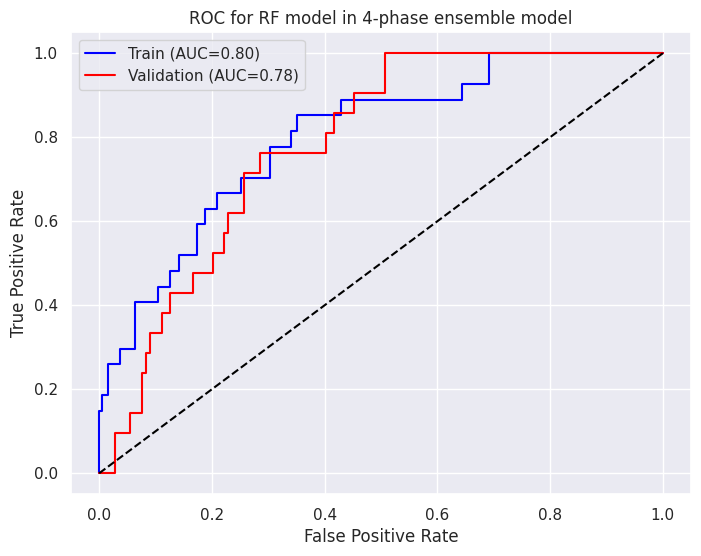

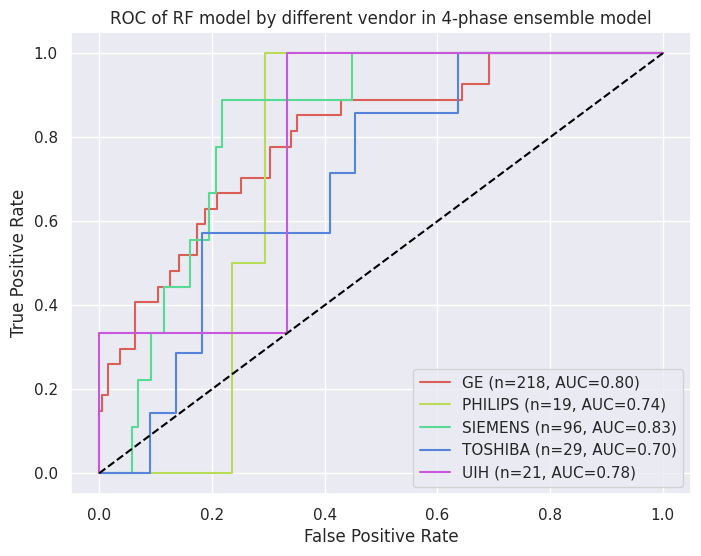

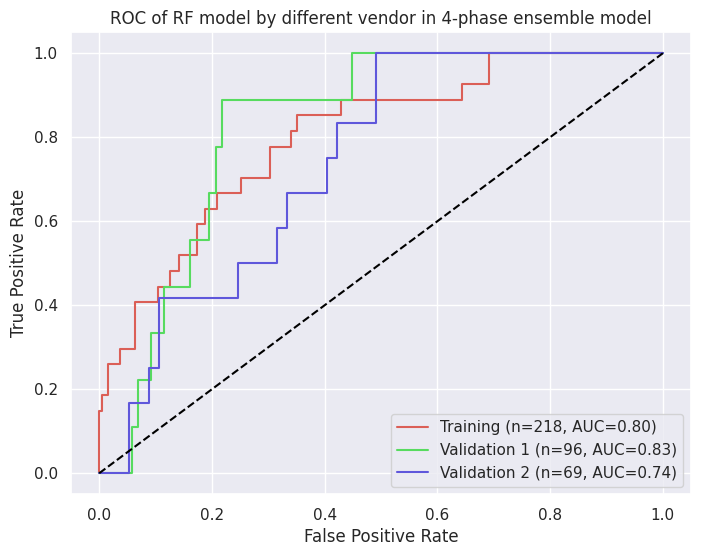

In [36]:
phase_results={}
time_format = "%Y-%m-%d-%H-%M-%S"
output_dir = "outputs-processing_ct4phase-{time}".format(
    time=datetime.datetime.now().strftime(time_format)
)

for phase in "cavd":
    results = phase_results.get(phase, {})
    config = get_config(phase, output_dir)
    results["fs"] = select_features(config)
    results["bs"] = baysian_search(config, results["fs"]["cols_to_include"])
    model_params = config["model"]["params"]
    model_params.update(results["bs"]["opt"].best_params_)
    results["model"] = fit_model(config, model_params, results["fs"]["cols_to_include"])["model"]
    results["fi"] = plot_feature_importance(config, results["model"], results["fs"]["cols_to_include"])
    results["valid"] = validation(config, results["model"], results["fs"]["cols_to_include"])
    results["vendor"] = plot_roc_vendor(config, results["model"], results["fs"]["cols_to_include"])
    results["vendor_grp"] = plot_roc_vendor(config, results["model"], results["fs"]["cols_to_include"], "custom_vendor-group", "vendorgrp")
    phase_results[phase] = results
    plt.close("all")

phase_results["ensemb"] = ensemble(
    config,
    dict([(phase, phase_results[phase]["model"]) for phase in "cavd"]),
    dict([(phase, phase_results[phase]["fs"]["cols_to_include"]) for phase in "cavd"]),
    plot_train_valid=True, delong=False
)
phase_results["ensemb_grp"] = ensemble(
    config,
    dict([(phase, phase_results[phase]["model"]) for phase in "cavd"]),
    dict([(phase, phase_results[phase]["fs"]["cols_to_include"]) for phase in "cavd"]),
    "custom_vendor-group", "vendorgrp",
    plot_train_valid=False, delong=True, perm=True
)

# Save data
with open(f"{config['path']['output_dir']}/data.pkl", "wb") as f:
    pickle.dump({
        "data": config["data"],
        "cv": config["cv"],
    }, f)

# Save models
with open(f"{config['path']['output_dir']}/model.pkl", "wb") as f:
    _models = {}
    for phase in "cavd":
        _models[phase] = {
            "model": phase_results[phase]["model"],
            "features": phase_results[phase]["fs"]["cols_to_include"],
        }
    pickle.dump(_models, f)

# Save model parameters and metrices
with open(f"{config['path']['output_dir']}/params.json", "w") as f:
    config_plain = config.copy()
    config_plain["cv"] = str(config_plain["cv"])
    del config_plain["data"], config_plain["phase"]
    json.dump(config_plain, f, indent=2)

with open(f"{config['path']['output_dir']}/metrics.json", "w") as f:
    metrics_results = {}
    for phase in "cavd":
        metrics_results[phase] = {
            "valid": phase_results[phase]["valid"],
            "vendor": phase_results[phase]["vendor"],
            "vendor_grp": phase_results[phase]["vendor_grp"]
        }
    
    metrics_results["ensemb"] = phase_results["ensemb"].copy()
    metrics_results["ensemb_grp"] = phase_results["ensemb_grp"].copy()
    metrics_results["ensemb"]["coef"] = metrics_results["ensemb"]["coef"].flatten().tolist()
    metrics_results["ensemb"]["intercept"] = metrics_results["ensemb"]["intercept"].item()
    metrics_results["ensemb_grp"]["coef"] = metrics_results["ensemb_grp"]["coef"].flatten().tolist()
    metrics_results["ensemb_grp"]["intercept"] = metrics_results["ensemb_grp"]["intercept"].item()
    json.dump(deep_map(metrics_results, lambda x: [float(i) for i in x] if isinstance(x, list) else float(x)), f, indent=2)

# Tables

In [37]:
df.groupby("custom_vendor").size() / 4

custom_vendor
GE         218.0
PHILIPS     19.0
SIEMENS     96.0
TOSHIBA     29.0
UIH         21.0
dtype: float64

<Axes: xlabel='original_shape_Maximum2DDiameterSlice', ylabel='Count'>

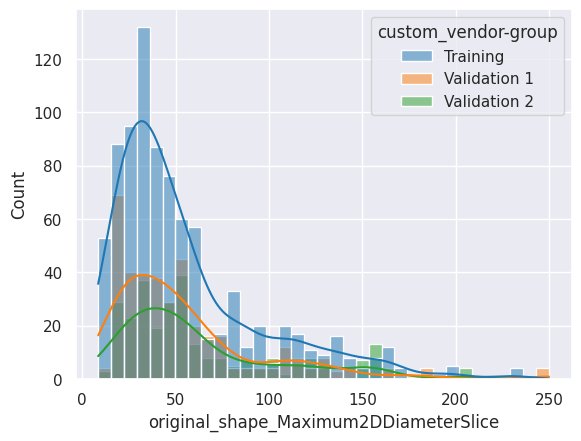

In [38]:
sns.histplot(data=df, x="original_shape_Maximum2DDiameterSlice", hue="custom_vendor-group", kde=True)

In [39]:
def t_test(value_col, table, filter_vals=[True, False], filter_col="custom_ki67-gt-10"):
    args = [table[table[filter_col] == f][value_col] for f in filter_vals]
    return S.ttest_ind(*args)[1]

def chi2_test(value_col, table, filter_vals=[True, False], filter_col="custom_ki67-gt-10"):
    data = table[table[filter_col].map(lambda x: x in filter_vals)]
    pivot = data.groupby([value_col, filter_col]).size().reset_index().pivot_table(index=value_col, columns=filter_col)
    return S.chi2_contingency(pivot)[1]

def fisher_exact_test(value_col, table, filter_vals=[True, False], filter_col="custom_ki67-gt-10"):
    data = table[table[filter_col].map(lambda x: x in filter_vals)]
    pivot = data.groupby([value_col, filter_col]).size().reset_index().pivot_table(index=value_col, columns=filter_col)
    return S.fisher_exact(pivot)[1]

def anova_test(value_col, table, filter_vals=[True, False], filter_col="custom_ki67-gt-10"):
    args = [table[table[filter_col] == v][value_col] for v in filter_vals]
    return S.f_oneway(*args)[1]

In [40]:
def _format_p(p: float):
    return "%.3f" % p if p >= 0.001 else "< 0.001"

def _format_index(vendor: str, hipi: bool | str):
    if not isinstance(hipi, bool):
        return (vendor, hipi)
    hipi_text = "High Ki-67 PI" if hipi else "Low Ki-67 PI"
    hipi_text = f"{hipi_text} (n = {_size[vendor][hipi]})"
    return (vendor, hipi_text)

In [41]:
results = pd.DataFrame()
dfc = index_lv2(df, 'c')
_size = dfc.groupby(["custom_vendor-group"]).size()
vendor_groups = _size.index.get_level_values(0).drop_duplicates()
# Age
_age_mean = dfc.groupby(["custom_vendor-group"])["custom_age-value"].mean()
_age_std = dfc.groupby(["custom_vendor-group"])["custom_age-value"].std()
_age_p_value = anova_test("custom_age-value", dfc, filter_vals=vendor_groups, filter_col="custom_vendor-group")
_age_p = _format_p(_age_p_value)
_age = pd.concat([_age_mean, _age_std], axis=1).apply(lambda r: "%.2f ± %.2f" % (r[0], r[1]), axis=1)
_age.loc["p"] = _age_p
_age = _age.rename("Age (years)").sort_index()
# Gender
_gender_data = dfc.groupby(["custom_gender-value", "custom_vendor-group"]).size().reset_index()
_gender_pivot = _gender_data.pivot_table(0, index=["custom_vendor-group"], columns="custom_gender-value").fillna(0)
_gender_pivot_pct = (_gender_pivot.T / _size).T
_gender_text = pd.DataFrame(np.apply_along_axis(lambda r: "%3d (%.2f%%)" % (r[0], r[1] * 100), 0, np.stack([_gender_pivot, _gender_pivot_pct])), index=_gender_pivot.index, columns=_gender_pivot.columns)
_gender_text = _gender_text.rename({
    0: "Female",
    1: "Male",
}, axis=1)
_gender_p_value = chi2_test("custom_gender-value", dfc, filter_vals=vendor_groups, filter_col="custom_vendor-group")
_gender_p = pd.Series({"p": _format_p(_gender_p_value)}, name="Gender")

# Size
_diameter_mean = dfc.groupby(["custom_vendor-group"])["original_shape_Maximum2DDiameterSlice"].mean()
_diameter_std = dfc.groupby(["custom_vendor-group"])["original_shape_Maximum2DDiameterSlice"].std()
_diameter_p_value = anova_test("original_shape_Maximum2DDiameterSlice", dfc, filter_vals=vendor_groups, filter_col="custom_vendor-group")
_diameter_p = _format_p(_diameter_p_value)
_diameter = pd.concat([_diameter_mean, _diameter_std], axis=1).apply(lambda r: "%.2f ± %.2f" % (r[0], r[1]), axis=1)
_diameter.loc["p"] = _diameter_p
_diameter = _diameter.rename("Diameter (mm)").sort_index()

# Ki-67
_ki67_data = dfc.groupby(["custom_ki67-gt-10", "custom_vendor-group"]).size().reset_index()
_ki67_pivot = _ki67_data.pivot_table(0, index=["custom_vendor-group"], columns="custom_ki67-gt-10").fillna(0)
_ki67_pivot_pct = (_ki67_pivot.T / _size).T
_ki67_text = pd.DataFrame(np.apply_along_axis(lambda r: "%3d (%.2f%%)" % (r[0], r[1] * 100), 0, np.stack([_ki67_pivot, _ki67_pivot_pct])), index=_ki67_pivot.index, columns=_ki67_pivot.columns)
_ki67_text = _ki67_text.rename({
    0: "Ki-67 ≤ 10%",
    1: "Ki-67 > 10%",
}, axis=1)
_ki67_p_value = chi2_test("custom_ki67-gt-10", dfc, filter_vals=vendor_groups, filter_col="custom_vendor-group")
_ki67_p = pd.Series({"p": _format_p(_ki67_p_value)}, name="Ki-67 PI")

# CT enhancement characteristics
def enhancement_feature(col, phase="max"):
    _data = df.reset_index()[["custom_studyId", "custom_vendor-group", "custom_phase", col]]
    _data = _data.pivot_table(values=col, index=["custom_studyId", "custom_vendor-group"], columns="custom_phase").reset_index(1)
    if phase == "max":
        _data[col] = (_data[list("cavd")].max(1) / _data["c"])
    else:
        _data[col] = (_data[phase] / _data["c"])
    _data_mean = _data.groupby(["custom_vendor-group"])[col].mean()
    _data_std = _data.groupby(["custom_vendor-group"])[col].std()
    _data_p_value = anova_test(col, _data, filter_vals=vendor_groups, filter_col="custom_vendor-group")
    _data_p = _format_p(_data_p_value)
    _data_text = pd.concat([_data_mean, _data_std], axis=1).apply(lambda r: "%.2f ± %.2f" % (r[0], r[1]), axis=1)
    _data_text.loc["p"] = _data_p
    _data_text = _data_text.rename(col.replace("original_firstorder_", "Enhancement of ") + " Intensity (%)").sort_index()
    return _data_text
_cer = enhancement_feature("original_firstorder_Median").rename("CER (%)")

results = pd.concat([results, _age, _gender_p, _gender_text, _diameter, _ki67_p, _ki67_text, _cer], axis=1)

_sort_vendorgrps = {"Training": 0, "Validation 1": 1, "Validation 2": 2}
results = results.sort_index(axis=0, key=lambda x: x.map(_sort_vendorgrps))
results.rename(index=lambda x: "%s (n = %d)" % (x, _size[x]) if x in vendor_groups else x, inplace=True)
results = results.T.fillna('')
results

,Training (n = 218),Validation 1 (n = 96),Validation 2 (n = 69),p
Age (years),60.91 ± 11.94,62.38 ± 12.71,61.33 ± 13.07,0.627
Gender,,,,0.570
Female,110 (50.46%),43 (44.79%),36 (52.17%),
Male,108 (49.54%),53 (55.21%),33 (47.83%),
Diameter (mm),55.01 ± 40.64,54.96 ± 41.08,61.80 ± 42.43,0.461
Ki-67 PI,,,,0.307
Ki-67 ≤ 10%,191 (87.61%),87 (90.62%),57 (82.61%),
Ki-67 > 10%,27 (12.39%),9 (9.38%),12 (17.39%),
CER (%),2.26 ± 0.81,2.27 ± 0.77,2.24 ± 0.76,0.971


In [42]:
results.to_excel("tables/table-1.xlsx")

In [43]:
results = pd.DataFrame()
dfc = index_lv2(df, 'c')
_size = dfc.groupby(["custom_vendor-group", "custom_ki67-gt-10"]).size()
vendor_groups = _size.index.get_level_values(0).drop_duplicates()
# Age
_age_mean = dfc.groupby(["custom_vendor-group", "custom_ki67-gt-10"])["custom_age-value"].mean()
_age_std = dfc.groupby(["custom_vendor-group", "custom_ki67-gt-10"])["custom_age-value"].std()
_age_p_value = pd.Series(
    [t_test("custom_age-value", dfc[dfc["custom_vendor-group"] == vendor]) for vendor in vendor_groups],
    index=[(vendor, "p") for vendor in vendor_groups],
)
_age_p = _age_p_value.map(_format_p)
_age = pd.concat([_age_mean, _age_std], axis=1).apply(lambda r: "%.2f ± %.2f" % (r[0], r[1]), axis=1)
_age = pd.concat([_age, _age_p], axis=0).rename("Age (years)").sort_index()
# Gender
_gender_data = dfc.groupby(["custom_gender-value", "custom_vendor-group", "custom_ki67-gt-10"]).size().reset_index()
_gender_pivot = _gender_data.pivot_table(0, index=["custom_vendor-group", "custom_ki67-gt-10"], columns="custom_gender-value").fillna(0)
_gender_pivot_pct = (_gender_pivot.T / _size).T
_gender_text = pd.DataFrame(np.apply_along_axis(lambda r: "%3d (%.2f%%)" % (r[0], r[1] * 100), 0, np.stack([_gender_pivot, _gender_pivot_pct])), index=_gender_pivot.index, columns=_gender_pivot.columns)
_gender_text = _gender_text.rename({
    0: "Female",
    1: "Male",
}, axis=1)
_gender_p_value = pd.Series(
    [fisher_exact_test("custom_gender-value", dfc[dfc["custom_vendor-group"] == vendor]) for vendor in vendor_groups],
    index=[(vendor, "p") for vendor in vendor_groups],
    name="Gender",
)
_gender_p = _gender_p_value.map(_format_p)

# Size
_diameter_mean = dfc.groupby(["custom_vendor-group", "custom_ki67-gt-10"])["original_shape_Maximum2DDiameterSlice"].mean()
_diameter_std = dfc.groupby(["custom_vendor-group", "custom_ki67-gt-10"])["original_shape_Maximum2DDiameterSlice"].std()
_diameter_p_value = pd.Series(
    [t_test("original_shape_Maximum2DDiameterSlice", dfc[dfc["custom_vendor-group"] == vendor]) for vendor in vendor_groups],
    index=[(vendor, "p") for vendor in vendor_groups],
)
_diameter_p = _diameter_p_value.map(_format_p)
_diameter = pd.concat([_diameter_mean, _diameter_std], axis=1).apply(lambda r: "%.2f ± %.2f" % (r[0], r[1]), axis=1)
_diameter = pd.concat([_diameter, _diameter_p], axis=0).rename("Diameter (mm)").sort_index()

# Contrast enhancement rate
_cer_mean = dfc.groupby(["custom_vendor-group", "custom_ki67-gt-10"])["custom_cer"].mean()
_cer_std = dfc.groupby(["custom_vendor-group", "custom_ki67-gt-10"])["custom_cer"].std()
_cer_p_value = pd.Series(
    [t_test("custom_cer", dfc[dfc["custom_vendor-group"] == vendor]) for vendor in vendor_groups],
    index=[(vendor, "p") for vendor in vendor_groups],
)
_cer_p = _cer_p_value.map(_format_p)
_cer = pd.concat([_cer_mean, _cer_std], axis=1).apply(lambda r: "%.2f ± %.2f" % (r[0], r[1]), axis=1)
_cer = pd.concat([_cer, _cer_p], axis=0).rename("CER (%)").sort_index()

results = pd.concat([results, _age, _gender_p, _gender_text, _diameter, _cer], axis=1)

results.index = _age.index.map(lambda x: _format_index(x[0], x[1])).rename(["", ""])
_sort_vendorgrps = {"Training": 0, "Validation 1": 1, "Validation 2": 2}
results = results.sort_index(axis=0, key=lambda x: x.map(_sort_vendorgrps))
results = results.T.fillna('')
results

Training                                 
              Low Ki-67 PI (n = 191) High Ki-67 PI (n = 27)      p   
Age (years)            61.42 ± 11.70          57.33 ± 13.25  0.096  \
Gender                                                       0.310   
Female                   99 (51.83%)            11 (40.74%)          
Male                     92 (48.17%)            16 (59.26%)          
Diameter (mm)          51.68 ± 39.77          78.55 ± 39.60  0.001   
CER (%)                  2.30 ± 0.82            1.96 ± 0.70  0.042   

                       Validation 1                                
              Low Ki-67 PI (n = 87) High Ki-67 PI (n = 9)      p   
Age (years)           62.59 ± 13.24          60.33 ± 5.24  0.615  \
Gender                                                     0.181   
Female                  41 (47.13%)            2 (22.22%)          
Male                    46 (52.87%)            7 (77.78%)          
Diameter (mm)         51.28 ± 39.51         90.52 ± 41.03  0.006   
CER (%)                 2.33 ± 0.78           1.75 ± 0.36  0.030   

                       Validation 2                                
              Low Ki-67 PI (n = 57) High Ki-67 PI (n = 12)      p  
Age (years)           62.30 ± 13.14          56.75 ± 12.17  0.183  
Gender                                                      1.000  
Female                  30 (52.63%)             6 (50.00%)         
Male                    27 (47.37%)             6 (50.00%)         
Diameter (mm)         55.79 ± 38.18          90.36 ± 51.32  0.009  
CER (%)                 2.32 ± 0.79            1.88 ± 0.50  0.070

In [44]:
results.to_excel("tables/table-2.xlsx")

In [45]:
results = pd.DataFrame(index=pd.MultiIndex.from_tuples([(v, i) for v in vendor_groups for i in ["AUC", "accuracy", "sensitivity", "specificity"]]))
for phase in "cavd":
    for vendor_grp in vendor_groups:
        results.loc[(vendor_grp, "AUC"), phase] = phase_results[phase]["vendor_grp"][vendor_grp]["auc"]
        results.loc[(vendor_grp, "accuracy"), phase] = phase_results[phase]["vendor_grp"][vendor_grp]["acc"]
        results.loc[(vendor_grp, "sensitivity"), phase] = phase_results[phase]["vendor_grp"][vendor_grp]["sensitivity"]
        results.loc[(vendor_grp, "specificity"), phase] = phase_results[phase]["vendor_grp"][vendor_grp]["specificity"]

# for (ensemb_name, display_name) in zip(("ensemb_grp", "ensemb_grp-clin"), (r"ensemble (radiomics)", r"ensemble (radiomics + clinical)")):
for (ensemb_name, display_name) in zip(("ensemb_grp", ), ("ensemble (radiomics)", )):
    for vendor_grp in vendor_groups:
        results.loc[(vendor_grp, "AUC"), display_name] = phase_results[ensemb_name][vendor_grp]["auc"]
        results.loc[(vendor_grp, "accuracy"), display_name] = phase_results[ensemb_name][vendor_grp]["acc"]
        results.loc[(vendor_grp, "sensitivity"), display_name] = phase_results[ensemb_name][vendor_grp]["sensitivity"]
        results.loc[(vendor_grp, "specificity"), display_name] = phase_results[ensemb_name][vendor_grp]["specificity"]

_vendor_size = _size = df.groupby(["custom_vendor-group"]).size() / 4
results.sort_index(axis=1, key=lambda x: x.map(_sort_vendorgrps), inplace=True)
results_text = results.applymap(lambda x: '%.3f' % x)
for v in vendor_groups[1:]:
    m = np.max(results.loc[(v, "AUC"), :].values)
    for i in np.argwhere(results.loc[(v, "AUC"), :].values == m):
        i = i.item()
        results_text.iloc[results.index.get_loc((v, "AUC")), i] = "\textbf{%s}" % results_text.iloc[results.index.get_loc((v, "AUC")), i]
results.index = results.index.map(lambda x: ("%s (n = %d)" % (x[0], _vendor_size[x[0]]), x[1]))
results_text.rename(columns=PHASE_NAME, inplace=True)
results_text.rename_axis(index=["Dataset", "Metric"], columns="Model", inplace=True)
results_text = results_text.sort_index(axis=0, key=lambda x: x.map(_sort_vendorgrps))
results_text

Model                    non-contrast arterial venous         delayed   
Dataset      Metric                                                     
Training     AUC                0.792    0.803  0.791           0.801  \
             accuracy           0.739    0.757  0.752           0.743   
             sensitivity        0.741    0.667  0.667           0.704   
             specificity        0.738    0.770  0.764           0.749   
Validation 1 AUC                0.822    0.814  0.807  \textbf{0.834}   
             accuracy           0.708    0.760  0.771           0.688   
             sensitivity        0.889    0.667  0.667           0.889   
             specificity        0.690    0.770  0.782           0.667   
Validation 2 AUC                0.711    0.725  0.737           0.709   
             accuracy           0.667    0.696  0.696           0.609   
             sensitivity        0.667    0.500  0.500           0.500   
             specificity        0.667    0.737  0.737           0.632   

Model                    ensemble (radiomics)  
Dataset      Metric                            
Training     AUC                        0.801  
             accuracy                   0.674  
             sensitivity                0.852  
             specificity                0.649  
Validation 1 AUC                        0.826  
             accuracy                   0.594  
             sensitivity                0.889  
             specificity                0.563  
Validation 2 AUC               \textbf{0.741}  
             accuracy                   0.623  
             sensitivity                0.833  
             specificity                0.579

In [46]:
results_text.to_excel("tables/table-3.xlsx")

# Figures

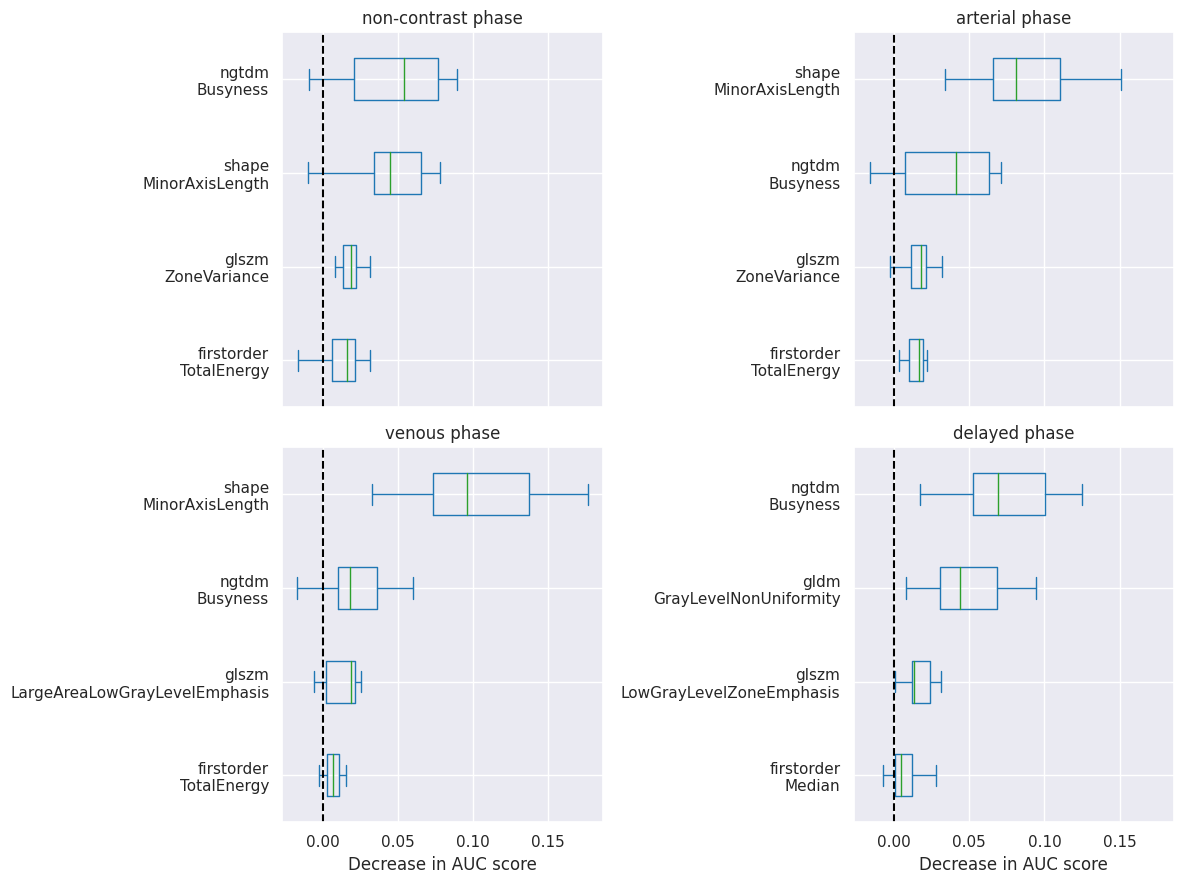

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9), sharex=True)

for i, phase in enumerate("cavd"):
    col = i % 2
    row = i // 2
    results = phase_results.get(phase, {})
    cols_to_include = results["fs"]["cols_to_include"]
    model = results["model"]
    config = get_config(phase, output_dir)
    X_train = config["data"]["X_train"][cols_to_include]
    y_train = config["data"]["y_train"]
    X_test = config["data"]["X_test"][cols_to_include]
    y_test = config["data"]["y_test"]

    results_train = permutation_importance(model, X_train, y_train, scoring=lambda est, x, y: roc_auc_score(y, est.predict_proba(x)[:, 1]), random_state=RANDOM_STATE, n_repeats=10, n_jobs=-1)

    results["feature_importances"] = pd.DataFrame(
        np.array([cols_to_include, model.feature_importances_, results_train["importances_mean"]]).T,
        columns=["Column", "Importance", "Permutation Importance (train)"]
    ).sort_values("Permutation Importance (train)", ascending=False).set_index("Column")

    # Plot train
    sorted_importances_idx = results_train.importances_mean.argsort()
    importances_train = pd.DataFrame(
        results_train.importances[sorted_importances_idx].T,
        columns=[c.replace("original_", "").replace("_", "\n") for c in cols_to_include[sorted_importances_idx]],
    )
    importances_train.plot(kind="box", vert=False, whis=10, ax=ax[row][col])
    ax[row][col].set_title(f"{PHASE_NAME[phase]} phase")
    ax[row][col].axvline(x=0, color="k", linestyle="--")
    ax[row][col].set_xlabel("Decrease in AUC score")

fig.tight_layout()

plt.savefig(f"{config['path']['output_dir']}/figure-permutation-importance.jpg", dpi=300)

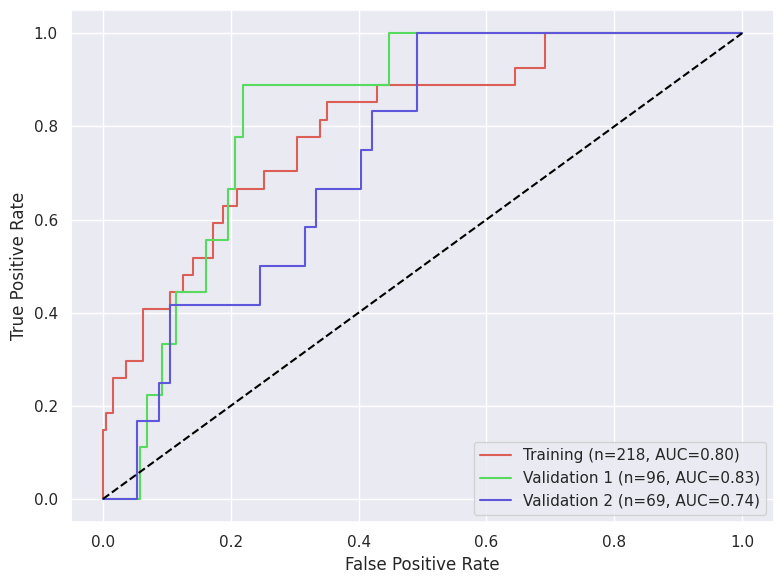

In [48]:
ensemble(
    config,
    dict([(phase, phase_results[phase]["model"]) for phase in "cavd"]),
    dict([(phase, phase_results[phase]["fs"]["cols_to_include"]) for phase in "cavd"]),
    "custom_vendor-group", "vendorgrp",
    plot_train_valid=False, delong=True
)
plt.title("")
handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
plt.savefig(f"{config['path']['output_dir']}/figure-roc-ensemble.jpg", dpi=300)

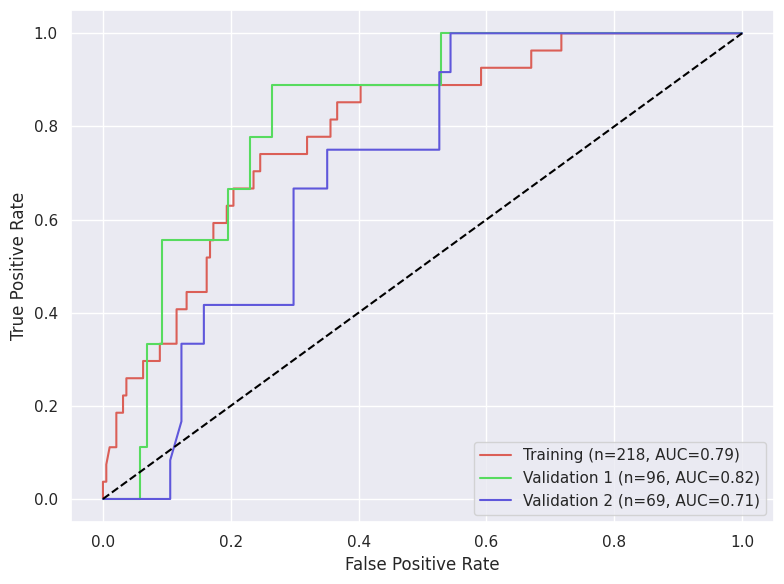

In [49]:
config = get_config("c", output_dir)
results = phase_results.get("c", {})
plot_roc_vendor(config, results["model"], results["fs"]["cols_to_include"], "custom_vendor-group", "vendorgrp")
plt.title("")
handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
plt.savefig(f"{config['path']['output_dir']}/figure-roc-noncontrast.jpg", dpi=300)

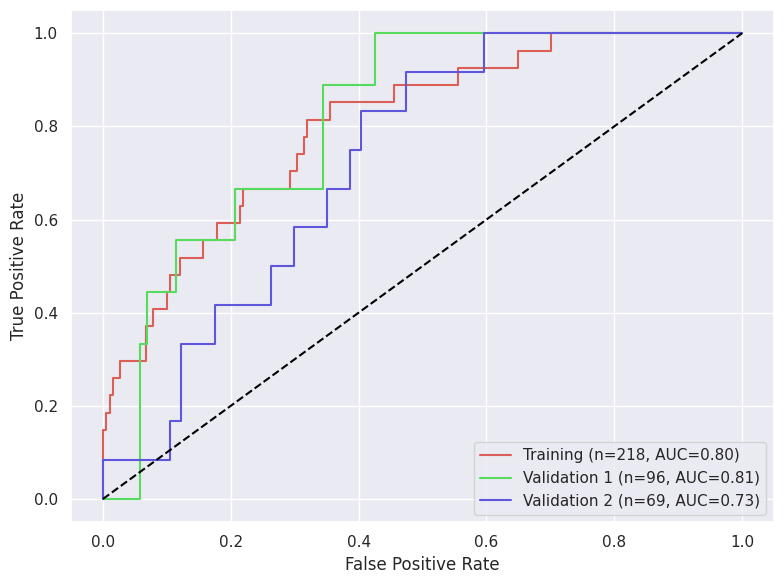

In [50]:
config = get_config("a", output_dir)
results = phase_results.get("a", {})
plot_roc_vendor(config, results["model"], results["fs"]["cols_to_include"], "custom_vendor-group", "vendorgrp")
plt.title("")
handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
plt.savefig(f"{config['path']['output_dir']}/figure-roc-arterial.jpg", dpi=300)

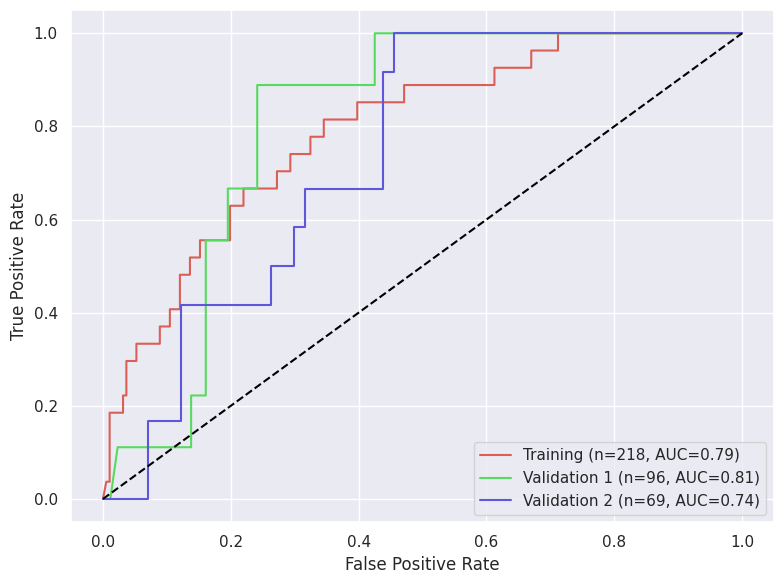

In [51]:
config = get_config("v", output_dir)
results = phase_results.get("v", {})
plot_roc_vendor(config, results["model"], results["fs"]["cols_to_include"], "custom_vendor-group", "vendorgrp")
plt.title("")
handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
plt.savefig(f"{config['path']['output_dir']}/figure-roc-venous.jpg", dpi=300)

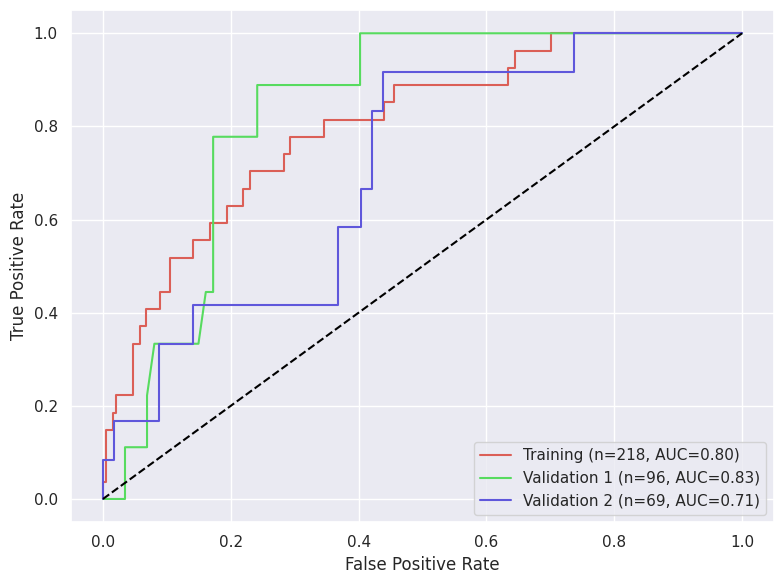

In [52]:
config = get_config("d", output_dir)
results = phase_results.get("d", {})
plot_roc_vendor(config, results["model"], results["fs"]["cols_to_include"], "custom_vendor-group", "vendorgrp")
plt.title("")
handles, labels = plt.gca().get_legend_handles_labels()
plt.tight_layout()
plt.savefig(f"{config['path']['output_dir']}/figure-roc-delayed.jpg", dpi=300)